# Radiometry in the spectrograph

In practice, the pupil of the spectrograph is lit by a **Gaussian beam** from the output waveguide. This Gaussian beam distribution is theoretically infinite, so a **finite** pupil will always crop the illumination and loose some of the flux.

An inportant contribution to the resolution of the spectrograph is the diffraction. For a given pupil, the best resolution (smallest FWHM) is **obtained with a uniform illumination of the pupil**.

Getting closer to a uniform illumination means limiting the pupil only to **the top of the Gaussian crest**, where it is the flattest, which would also **discard the most light**.

One solution would be PIAA lenses, but we have neither the budget nor the time for such tricks.

The approach we take is to settle for an acceptable throughput $\eta$, then look at how much we need to oversize the spectrograph beam to **preserve the same FWHM** with this **cropped Gaussian profile**.

In [1]:
import scifysim as sf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sympy as sp
# optional:
from scifysim.utilities import fprint
plt.style.use("dark_background")

Building a model from scratch


# Description of the Gaussian beam profile

## We start with the Gaussian approx from Tepper 2014

### The gaussian approximation

In [2]:
r, x, y = sp.symbols("r, x, y", real=True)
lamb = sp.symbols("lambda", real=True, positive=True)
w, R, k = sp.symbols("w, R, k", real=True)
# q, the beam parameter
q = 1/(1/R - sp.I*lamb/(sp.pi*w**2))
qwaist = q.subs([(R, sp.oo)])
u = 1/q*sp.exp(-sp.I*k/2*(x**2+y**2)*1/q)
ur = 1/q*sp.exp(-sp.I*k/2*r**2*1/q)
uwaist = u.subs([(R, sp.oo),
                (k, 2*sp.pi/lamb)])

In [3]:
fprint(u, "u(x, y) = ")
fprint(ur, "u(r) = ")
fprint(uwaist, "u_{waist}(x, y) = ")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
urwaist = ur.subs([(R, sp.oo),
        (k, 2*sp.pi/lamb)])
urn = sp.lambdify((r, w, lamb),urwaist,modules="numpy")


In [5]:
w_0 = sp.symbols("w_0", real=True, positive=True)
z = sp.symbols("z", real=True)
zr = sp.pi*w_0**2/lamb
Rz = (z**2 + zr**2)/z # that one is not used for now
fprint(Rz, "R(z) = ")
wz = w_0*sp.sqrt(1+z**2/zr**2)
fprint(wz, "w(z) = ")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Pulling the parameters from Tepper et al. 2014

In [6]:
nclad, ncore = sp.symbols("n_{clad}, n_{core}", real=True, positive=True)

mywl = 3.5e-6
mymaxwl = 4.0e-6
nclad_GLS = 2.3159

### Parameters from Kenchington-Goldsmith & Gross (private communication)

In [7]:
wl_KG = 4.0e-6
mfd_KG_large = 30.e-6   #+-3µm
mfd_KG_small = 25.5e-6  #+-1 µm
mfd_KG_mean = np.mean([mfd_KG_large, mfd_KG_small])

In [8]:

NA = lamb/(sp.pi*w_0)
ncore = sp.sqrt((NA)**2 + nclad**2)
ncoren = sp.lambdify((nclad, w_0, lamb), ncore, modules="numpy")
print("nclad = ", nclad_GLS)
print("ncore = ", ncoren(nclad_GLS, mfd_KG_mean/2, wl_KG))
#best_w = mfd_KG_mean/2
#my_w_0 = mywl * (mfd_KG_mean/2)/wl_KG
w01 = mywl * (mfd_KG_mean/2)/wl_KG
w02 = mymaxwl * (mfd_KG_mean/2)/wl_KG
print(w01)
print(w02)

nclad =  2.3159
ncore =  2.3177173312270316
1.2140625e-05
1.3875e-05


In [9]:
# The parameters of the waveguide
my_NA = sp.N(NA.subs([(w_0, mfd_KG_mean/2),
                     (lamb, wl_KG)]))
print(f"Numerical Aperture (small angle approx): N.A. = {my_NA:.3f}")
#my_a = asim.injector.a
my_n_core = ncoren(nclad_GLS, mfd_KG_mean/2, wl_KG)

Numerical Aperture (small angle approx): N.A. = 0.092


# Throughput at the pupil of the spectrograph

## Defining a pupil diameter

In [10]:
design_beam_diameter = 14.8e-3 # Taken from A. Mazzoli on 2021/05/06
design_imager_focal_length = 57.0e-3
beam_diameter = 20e-3
focals = np.linspace(10.e-3, 100e-3, 200)
pitch_H2RG = 18.0e-6 # [m/pix]

Numerical aperture can be computed from there. In the small angle approximation:
$$N.A.(\lambda, w_0) = \lim\limits_{z \to \infty} \frac{dw}{dz} $$

In [11]:
NA_w = sp.limit(sp.diff(wz, z), z, sp.oo)
fprint(NA_w, r"N.A.(\lambda, w_0) = \lim\limits_{z \to \infty} \frac{dw}{dz} =")

<IPython.core.display.Math object>

In [12]:
D = sp.symbols("D", real=True, positive=True)
throughput = 1-sp.exp(-1/2*(D/2)**2/wz)

In [13]:
throughput

1 - exp(-0.125*D**2/(w_0*sqrt(lambda**2*z**2/(pi**2*w_0**4) + 1)))

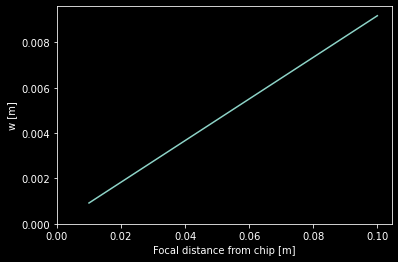

In [14]:
wzn = sp.lambdify((z, w_0, lamb), wz, modules="numpy")(focals, w01, mywl)
wzn2 = sp.lambdify((z, w_0, lamb), wz, modules="numpy")(focals, w02, mymaxwl)
plt.figure()
plt.plot(focals, wzn)
plt.ylabel("w [m]")
plt.xlabel("Focal distance from chip [m]")
plt.ylim(0, None)
plt.xlim(0,None)
plt.show()

In [15]:
ur_lamb = ur.subs([(k, 2*sp.pi/lamb),
                  (w, wz),
                  (R, Rz)])

fprint(ur_lamb, "u_{r}(r,z) = ")
ur_lamb_n = sp.lambdify((r,z, w_0, lamb), ur_lamb, modules="numpy")

<IPython.core.display.Math object>

xx, yy = np.meshgrid(np.linspace(-beam_diameter/2, beam_diameter/2, 300),
                    np.linspace(-beam_diameter/2, beam_diameter/2, 300))
rr = np.sqrt(xx**2 + yy**2)
pupil_extent = [np.min(xx), np.max(xx), np.min(yy), np.max(yy)]
plt.figure()
plt.imshow(rr, extent=pupil_extent)
plt.colorbar()
plt.xlabel("Pupil position [m]")
plt.show()

afocal = 40.0e-3
urs_afocal = ur_lamb_n(rr, afocal, w01, mywl)
plt.figure()
plt.imshow(np.abs(urs_afocal)/np.max(np.abs(urs_afocal)),
           vmin=0, extent=pupil_extent)
plt.colorbar()
plt.xlabel("Pupil position [m]")
plt.contour(rr, levels=[beam_diameter/2], extent=pupil_extent)
plt.show()

In [16]:
from xaosim import sft
from tqdm.notebook import tqdm

# With varying diameters

We want to sample various beam diameters at constant throughput.

## Build the function of intensity in the pupil

In [17]:
rmax, dpup, eta = sp.symbols("r_{max}, d_{pup}, eta", real=True, positive=True)
print(r"$\eta$ : the efficiency")
print(r"$r_{max}$ : Radius of the pupil")
print(r"$d_{pup}$ : Diameter of the pupil")

$\eta$ : the efficiency
$r_{max}$ : Radius of the pupil
$d_{pup}$ : Diameter of the pupil


In [18]:
beam_intensity = sp.Abs(ur_lamb)**2
fprint(beam_intensity, "I(r) = ")

<IPython.core.display.Math object>

## Now the flux encircled by a pupil of radius $r_{max}$

In [19]:
theta = sp.symbols("theta", real=True)
circled_integral = sp.Integral(2*sp.pi * sp.Abs(ur_lamb)**2 * r,
                               (r, 0, rmax),
                               (theta,0, 2*sp.pi))
fprint(sp.Integral( sp.Abs(ur_lamb)**2 * r, (r, 0, rmax), (theta, 0, 2*sp.pi)), "F(r_{max}) = ")
circled_flux = sp.simplify(sp.integrate(2*sp.pi * sp.Abs(ur_lamb)**2 * r, (r, 0, rmax)))
print("The circled flux as a function of aperture radius")
fprint(circled_flux, "F(r_{max}) = ")

<IPython.core.display.Math object>

The circled flux as a function of aperture radius


<IPython.core.display.Math object>

## Also for those who prefer diameters with $d_{pup}$

In [20]:
circled_flux_D = sp.simplify(circled_flux.subs([(rmax, dpup/2)]))
print("The circled flux as a function of aperture diameter")
fprint(circled_flux_D, "F(d_{pup}) = ")

The circled flux as a function of aperture diameter


<IPython.core.display.Math object>

## The expression of the total flux

In [21]:
Ftot = sp.simplify(sp.limit(circled_flux, rmax, sp.oo))
print("The total flux: ")
fprint(Ftot, "F_{tot} = ")

The total flux: 


<IPython.core.display.Math object>

In [22]:
Ftotn = sp.lambdify((z, w_0, lamb), Ftot, modules="numpy")
print("The flux does not vary with wavelength")
print(Ftotn(0, w01, mywl))
print(Ftotn(0, w02, mymaxwl))

The flux does not vary with wavelength
0.01322738915072647
0.013227389150726469


# Looking for iso flux F#

In [23]:
sols = sp.solve(circled_flux - eta*Ftot, rmax)
for i, asol in enumerate(sols):
    #fprint(sp.simplify(asol), "")
    pass
#sol[0].subs([(lamb, )])
print("Computing the radius of the isoflux pupil:")
NA = sp.symbols("NA", real=True, positive=True)
naeq = sp.Eq(NA, NA_w)
w0sub = sp.solve(naeq, w_0)[0]
# The solution 3 is the real positive one
solsub = sols[3].subs([(w_0, w0sub)])
fprint(solsub, r"r_{iso} (\eta, z) = ")

Computing the radius of the isoflux pupil:


<IPython.core.display.Math object>

This relationship reduces to an adjustment of the numerical aperture

In [24]:
NA_cor = sp.limit(solsub/z, z, sp.oo)
fprint(NA_cor, r"NA_{lens}(\eta) = \lim\limits_{z \to \infty}\frac{r_{pup}}{z} = ")
print("For example:")
fprint(sp.N(NA_cor.subs([(eta, 0.9)])), r"NA_{lens}(\eta=0.9) =")

<IPython.core.display.Math object>

For example:


<IPython.core.display.Math object>

In [25]:
Fnumber = 1/(2*NA_cor)
fprint(Fnumber, r"F\# = ")

<IPython.core.display.Math object>

In [26]:
w0small = mywl * (mfd_KG_small/2)/wl_KG
w0large = mywl * (mfd_KG_large/2)/wl_KG

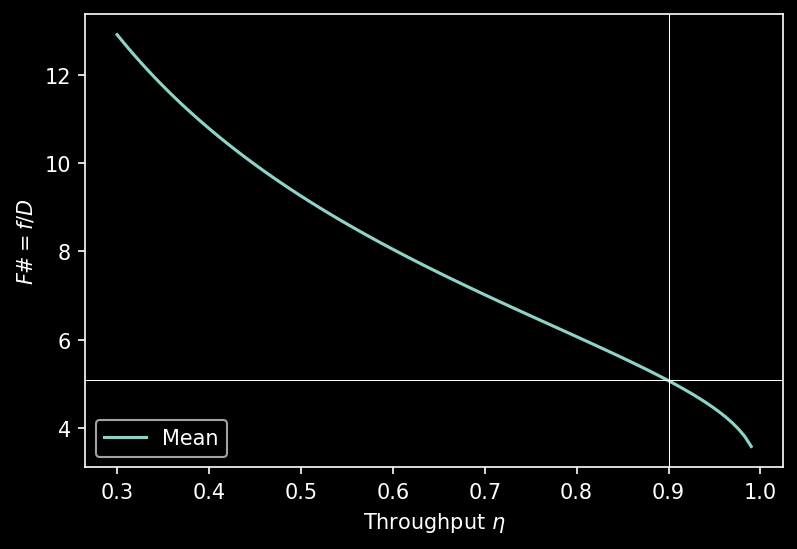

In [27]:
etas = np.linspace(0.3,0.99, 100)
Fnumbern = sp.lambdify((eta, w_0, lamb),
                       Fnumber.subs([(NA, NA_w)]),
                       modules="numpy")
plt.figure(dpi=150)
plt.plot(etas, Fnumbern(etas, w01, mywl), label="Mean")
#plt.plot(etas, Fnumbern(etas, w0small, mywl), label="Small mode")
#plt.plot(etas, Fnumbern(etas, w0large, mywl), label="Large mode")
plt.axvline(0.9, linewidth=0.5)
#plt.axhline(4.45, linewidth=0.5)
plt.axhline(5.1, linewidth=0.5)
plt.legend()

plt.xlabel(r"Throughput $\eta$")
plt.ylabel(r"$F\# = f/D$")
plt.show()

**Fig. 1** : The F# of a collimator as a function of its throughput. Guides highlight the example of $\eta = 0.9$, leading to $f/D \approx 5$.

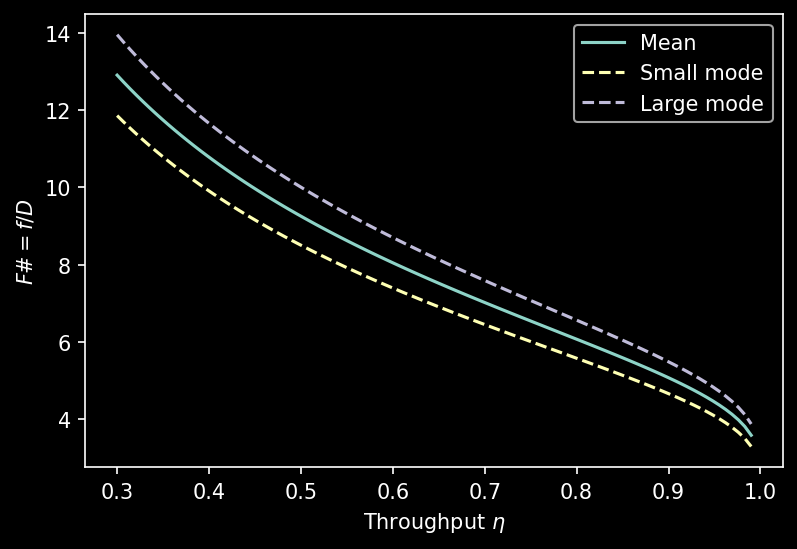

In [28]:
etas = np.linspace(0.3,0.99, 100)
Fnumbern = sp.lambdify((eta, w_0, lamb),
                       Fnumber.subs([(NA, NA_w)]),
                       modules="numpy")
plt.figure(dpi=150)
plt.plot(etas, Fnumbern(etas, w01, mywl), label="Mean")
plt.plot(etas, Fnumbern(etas, w0small, mywl),
         label="Small mode", linestyle="--")
plt.plot(etas, Fnumbern(etas, w0large, mywl),
         label="Large mode", linestyle="--")
plt.legend()
plt.xlabel(r"Throughput $\eta$")
plt.ylabel(r"$F\# = f/D$")
plt.show()

Or, as an expression of the diameter

In [29]:
dz = 2 * z * NA_cor.subs([(NA, NA_w)])
fprint(dz, r"d(z) = ")

<IPython.core.display.Math object>

## The PSF obtained with this illumination profile

## Now the focal lenght as a function of d

Here, we want to work at a *given diameter* at the *correct focal* length given by $\eta$. For this, we just have to isolate z.

In [30]:
d_eta = sp.symbols("d_eta", real=True, Positive=True)
eqd = sp.Eq(d_eta, dz)
z_eta = sp.solve(eqd, z)[0]
z_etan = sp.lambdify((eta, d_eta, w_0, lamb), z_eta, modules="numpy")

## Getting the FWHM of this profile

In [31]:
outsize = 500
outd = 10
pgrid_size = design_beam_diameter
xx, yy = np.meshgrid(np.linspace(-pgrid_size/2, pgrid_size/2, 300),
                    np.linspace(-pgrid_size/2, pgrid_size/2, 300))
rr = np.sqrt(xx**2 + yy**2)
pupil_extent = [np.min(xx), np.max(xx), np.min(yy), np.max(yy)]

# Adjusting the output scale so that the image size is consistent in botw wl
outd_max = outd * mywl/mymaxwl
# Defines the output image scale in lambda/D
# All output position scale is defined in lambda/D
outscale = outd/(outsize/2)
hw = outsize/2*outscale
outx, outy = np.meshgrid(np.linspace(-hw, hw, outsize),
                        np.linspace(-hw, hw, outsize))
outr = np.sqrt(outx**2 + outy**2)
out_extent = [np.min(outx), np.max(outx), np.min(outy), np.max(outy)]

In [32]:
deltas = []
for aneta in etas:
    anr = design_beam_diameter/2
    thefocal = z_etan(aneta, anr*2, w01, mywl)
    urs_afocal = ur_lamb_n(rr, thefocal, w01, mywl)
    urs_afocal_max = ur_lamb_n(rr, thefocal, w02, mymaxwl)
    pupil_illumination = urs_afocal*(rr<=anr)
    pupil_illumination_max = urs_afocal_max*(rr<=anr)
    output = sft.sft(np.abs(pupil_illumination), outsize, outd)
    output_max = sft.sft(np.abs(pupil_illumination_max), outsize, outd_max)
    outflat = sft.sft(np.abs(np.ones_like(urs_afocal)*(rr<=anr)), outsize, outd)
    outflat_max = sft.sft(np.abs(np.ones_like(urs_afocal)*(rr<=anr)), outsize, outd_max)
    # The mask of where the intensity is larger than half max
    outmask = np.abs(output)**2>=np.max(np.abs(output)**2)/2
    outmask_max = np.abs(output_max)**2>=np.max(np.abs(output_max)**2)/2
    outmask_flat = np.abs(outflat)**2>=np.max(np.abs(outflat)**2)/2
    outmask_flat_max = np.abs(outflat_max)**2>=np.max(np.abs(outflat_max)**2)/2
    #surfs.append(np.count_nonzero(outmask))
    #surfs_max.append(np.count_nonzero(outmask_max))
    fwhm = np.max(outr*outmask)
    fwhm_max = np.max(outr*outmask_max)
    fwhm_flat = np.max(outr*outmask_flat)
    fwhm_flat_max = np.max(outr*outmask_flat_max)
    deltas.append(fwhm/fwhm_flat)
deltas = np.array(deltas)

Therefore, we need to consider that:
$$FWHM_{Gaussian} = FWHM_{uniform}$$
requires that the beam diameter $D$ be:
$$D = \delta(\eta)\cdot D_{uniform}$$
where $\delta$ is the oversize parameter depending only on the throughput required $\eta$ with the relationship illustrated in the following plot:

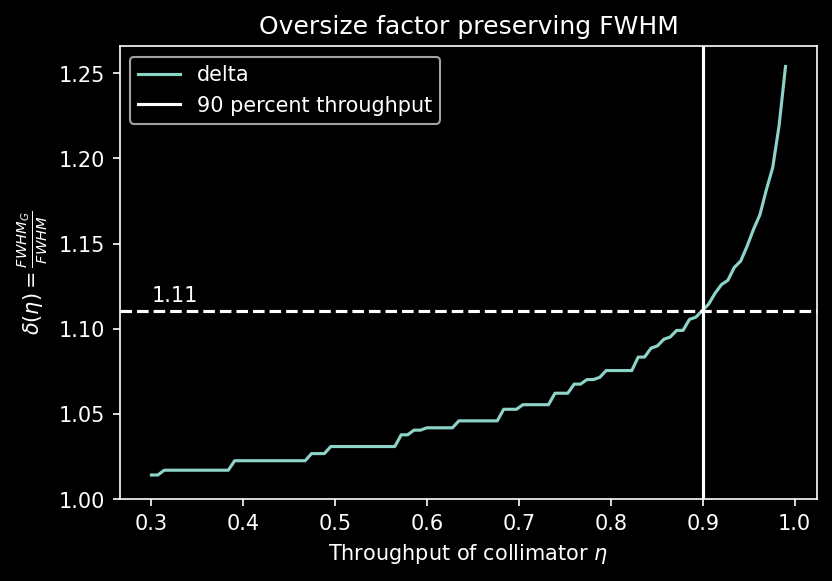

In [33]:
thl = 0.9
plt.figure(dpi=150)
plt.plot(etas, deltas, label=r"delta")
plt.ylim(1., None)
plt.xlabel(r"Throughput of collimator $\eta$")
plt.ylabel(r"$\delta(\eta) = \frac{FWHM_G}{FWHM}$")
plt.title("Oversize factor preserving FWHM")
plt.axvline(thl, label="%.0f percent throughput"%(100*thl))
deltathl = deltas[np.argmin(np.abs(etas-thl))]
plt.axhline(deltathl, linestyle="--")
plt.text(np.min(etas), 1.005* deltathl, "%.2f"%(deltathl))
plt.legend()
plt.show()

**Fig. 2** : The diameter oversizing factor as a function of the trhoughput $\eta$. Guides highlight the example of a 0.9 throughput system leading to $\delta=1.11$

# The resulting recommended parameters

In [34]:
NA_chip = sp.N(NA_w.subs([(lamb, mywl), 
              (w_0, w01)]))
print("The Numerical Aperture of the chip : ", NA_chip)
D_90 = deltathl*design_beam_diameter
Fnumber_90 = Fnumbern(thl, w01, mywl)
f_col = Fnumber_90*D_90
mag = design_imager_focal_length/f_col
print("The required diameter : ", D_90, "m")
print("The required F# : ", Fnumber_90)
print("The corresponding f : ", f_col, "m")
print("Spectrograph magnification : ", mag)

The Numerical Aperture of the chip :  0.0917650122331649
The required diameter :  0.016437010577534418 m
The required F# :  5.0780857588797
The corresponding f :  0.08346854933233253 m
Spectrograph magnification :  0.6828919450013776


# For the selected parameters

In [35]:
outsize = 1000
outd = 15
pgrid_size = D_90
xx, yy = np.meshgrid(np.linspace(-pgrid_size/2, pgrid_size/2, 300),
                    np.linspace(-pgrid_size/2, pgrid_size/2, 300))
rr = np.sqrt(xx**2 + yy**2)
pupil_extent = [np.min(xx), np.max(xx), np.min(yy), np.max(yy)]
pupil_extent_mm = 1e3*np.array(pupil_extent)
# Adjusting the output scale so that the image size is consistent in botw wl
outd_max = outd * mywl/mymaxwl
# Defines the output image scale in lambda/D
# All output position scale is defined in lambda/D
outscale = outd/(outsize/2)
hw = outsize/2*outscale
outx, outy = np.meshgrid(np.linspace(-hw, hw, outsize),
                        np.linspace(-hw, hw, outsize))
outr = np.sqrt(outx**2 + outy**2)
out_extent = [np.min(outx), np.max(outx), np.min(outy), np.max(outy)]

In [36]:
aneta = thl
anr = D_90/2
thefocal = f_col#z_etan(aneta, anr*2, w01, mywl)
urs_afocal = ur_lamb_n(rr, thefocal, w01, mywl)
urs_afocal_max = ur_lamb_n(rr, thefocal, w02, mymaxwl)
pupil_illumination = urs_afocal*(rr<=anr)
pupil_illumination_max = urs_afocal_max*(rr<=anr)
output = sft.sft(np.abs(pupil_illumination), outsize, outd)
output_max = sft.sft(np.abs(pupil_illumination_max), outsize, outd_max)
outflat = sft.sft(np.abs(np.ones_like(urs_afocal)*(rr<=anr)), outsize, outd)
outflat_max = sft.sft(np.abs(np.ones_like(urs_afocal)*(rr<=anr)), outsize, outd_max)
# The mask of where the intensity is larger than half max
outmask = np.abs(output)**2>=np.max(np.abs(output)**2)/2
outmask_max = np.abs(output_max)**2>=np.max(np.abs(output_max)**2)/2
outmask_flat = np.abs(outflat)**2>=np.max(np.abs(outflat)**2)/2
outmask_flat_max = np.abs(outflat_max)**2>=np.max(np.abs(outflat_max)**2)/2
#surfs.append(np.count_nonzero(outmask))
#surfs_max.append(np.count_nonzero(outmask_max))
fwhm = np.max(outr*outmask)
fwhm_max = np.max(outr*outmask_max)
fwhm_flat = np.max(outr*outmask_flat)
fwhm_flat_max = np.max(outr*outmask_flat_max)

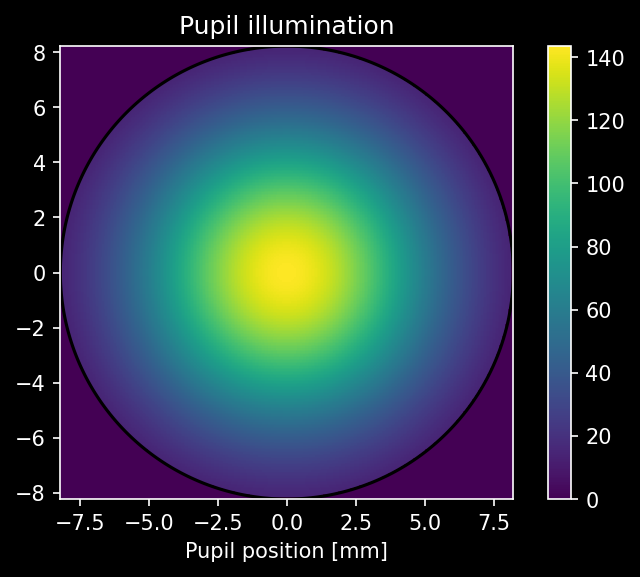

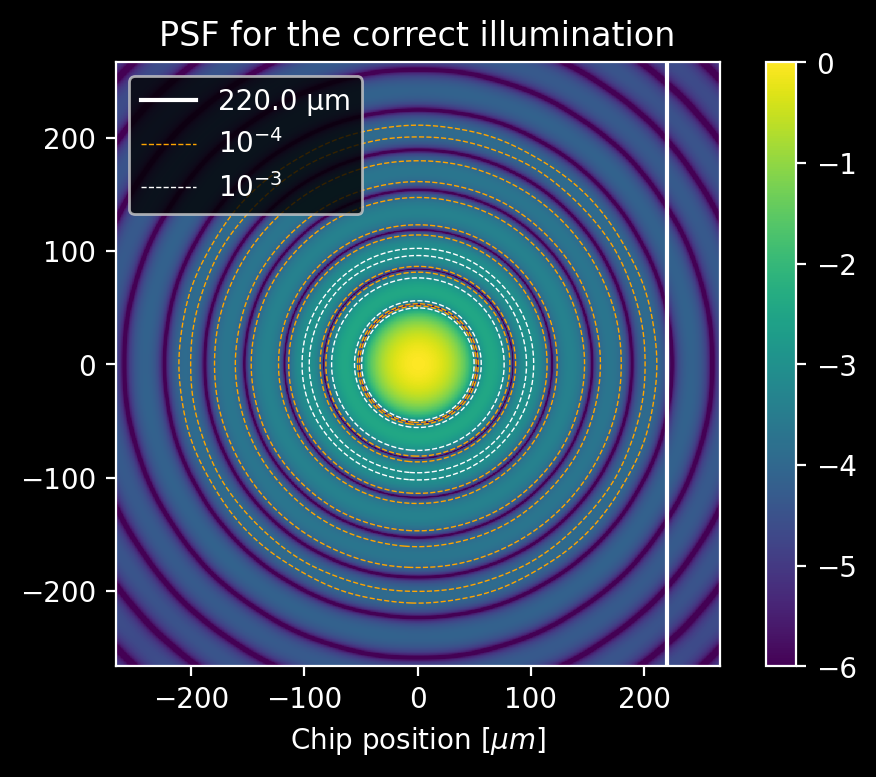

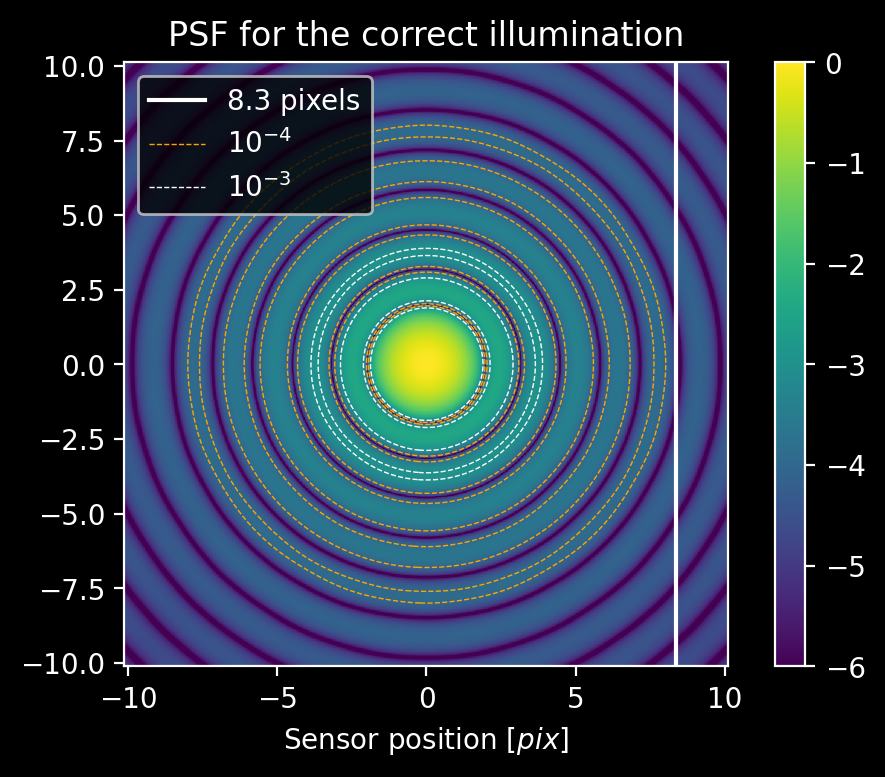

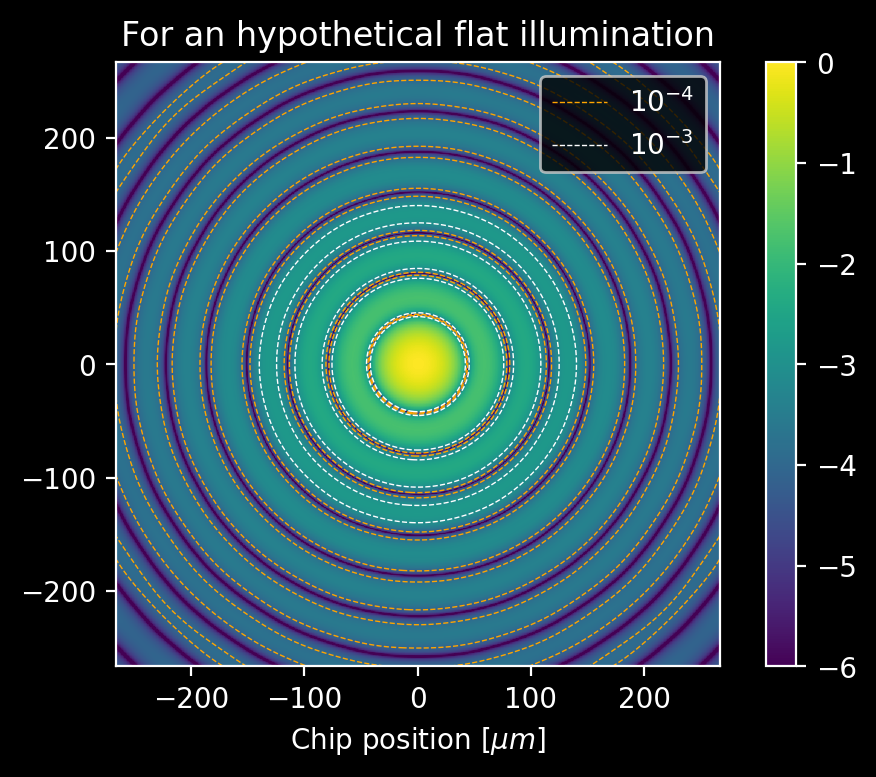

In [37]:

plt.figure(dpi=150)
plt.imshow(np.abs(pupil_illumination)**2, extent=pupil_extent_mm)
plt.colorbar()
plt.contour(rr, levels=[anr], extent=pupil_extent_mm,
           colors="k")
plt.xlabel("Pupil position [mm]")
plt.title("Pupil illumination")
plt.show()

rel_levels = np.array([1.0e-4, 1.0e-3])
colors = np.array(["orange", "w"])
clabels = [f"$10^{{-4}}$", f"$10^{{-3}}$"]
pos_chip = 220.0e-6
pos_im_pix = pos_chip * mag/pitch_H2RG

out_extent_pixels = 1/pitch_H2RG * design_imager_focal_length * mywl/(2*anr) * np.array(out_extent)
out_extent_chip = f_col * mywl/(2*anr) * np.array(out_extent)
out_extent_chip_microns = 1.0e6 * np.array(out_extent_chip) 
image = np.abs(output)**2
image_flat = np.abs(outflat)**2
clevels = rel_levels*np.max(image)
afig = plt.figure(dpi=200)
plt.imshow(np.log10(image/np.max(image)), extent=out_extent_chip_microns,
          vmin=-6)
plt.colorbar()
CS = plt.contour(image, extent=out_extent_chip_microns,
           levels=clevels, linestyles=["--"],
           colors=colors, linewidths=0.5)
vline = plt.axvline(pos_chip*1e6, label=f"{pos_chip*1e6} µm")
for i in range(len(clevels)):
    CS.collections[i].set_label(str(clabels[i]))
plt.legend()
plt.xlabel(r"Chip position $[\mu m]$")
plt.title("PSF for the correct illumination")
plt.show()


plt.figure(dpi=200)
plt.imshow(np.log10(image/np.max(image)), extent=out_extent_pixels,
          vmin=-6)
plt.colorbar()
CS = plt.contour(image, extent=out_extent_pixels,
           levels=clevels, linestyles=["--"],
           colors=colors, linewidths=0.5)
for i in range(len(clevels)):
    CS.collections[i].set_label(str(clabels[i]))
plt.axvline(pos_im_pix, label=f"{pos_im_pix:.1f} pixels")
plt.legend()
plt.xlabel(r"Sensor position $[pix]$")
plt.title("PSF for the correct illumination")
plt.show()


clevels_flat = rel_levels*np.max(image_flat)
plt.figure(dpi=200)
plt.imshow(np.log10(image_flat/np.max(image_flat)), extent=out_extent_chip_microns,
          vmin=-6)
plt.colorbar()
CS = plt.contour(image_flat, extent=out_extent_chip_microns,
           levels=clevels_flat, linestyles=["--"],
           colors=colors, linewidths=0.5)
for i in range(len(clevels)):
    CS.collections[i].set_label(str(clabels[i]))
plt.xlabel(r"Chip position $[\mu m]$")
plt.title("For an hypothetical flat illumination")
plt.legend()
plt.show()

**Fig. 3** : A representation of the recommended scenario with (top to bottom) 

* The pupil illumination in arbritrary units
* The PSF for the correct pupil illumination with dimensions in units of $\mu m$ on the chip
* The PSF for the correct pupil illumination with dimensions in units of pixels on the detector
* The PSF in the ideal case of uniform illumination

In [38]:
min_separation = np.max(outr[image>=1.0e-4*np.max(image)]) * f_col * mywl/(2*anr)
print("Minimum 10**-4 separation : ", min_separation*1e6, "[µm]")

Minimum 10**-4 separation :  211.26413335816855 [µm]
